In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "tesi2"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)


Your working directory was changed to /content/drive/My Drive/tesi2

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [ ]:
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import glob
import os
from PIL import Image
import torch.nn as nn
from torch import optim
import torch
from tqdm import tqdm
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2

batch_size = 2
deeplab = models.segmentation.deeplabv3_resnet50(pretrained=0, 
                                                 progress=1, 
                                                 num_classes=2)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [ ]:
class RoiSegModel(nn.Module):
    def __init__(self):
        super(RoiSegModel,self).__init__()
        self.dl = deeplab
        
    def forward(self, x):
        y = self.dl(x)['out']
        return y

In [ ]:
class SegDataset(Dataset):
    
    def __init__(self, parentDir, imageDir, maskDir):
        self.imageList = glob.glob(parentDir+'/'+imageDir+'/*')
        self.imageList.sort()
        self.maskList = glob.glob(parentDir+'/'+maskDir+'/*')
        self.maskList.sort()
    def __getitem__(self, index):
        
        preprocess = transforms.Compose([
                                    #transforms.Resize((288,384), 2),
                                    transforms.ToTensor(),
                                    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])
        
        X = Image.open(self.imageList[index]).convert('RGB')
        X = preprocess(X)
        
        #trfresize = transforms.Resize((384, 288), 2)
        #trftensor = transforms.ToTensor()
        
        yimg = Image.open(self.maskList[index]).convert('L')
        #y1 = trftensor(trfresize(yimg))
        y1 = preprocess(yimg)
        y1 = y1.type(torch.BoolTensor)
        y2 = torch.bitwise_not(y1)
        y = torch.cat([y2, y1], dim=0)
        
        return X, y
            
    def __len__(self):
        return len(self.imageList)

In [ ]:
calcTrain = SegDataset('DatasetInput', 'train', 'ROItrain')
calcTest = SegDataset('DatasetInput', 'test', 'ROItest')

In [ ]:
def pad_collate(batch):
    X, y = zip(*batch)
    X = list(X)
    y = list(y)
    maxw, maxh = 0, 0 

    for img in X:
        _, w, h = img.shape
        maxw = max(w, maxw)
        maxh = max(h, maxh)

    for i, (img, roi) in enumerate(zip(X,y)):
        _, w, h = img.shape
        diff_w = maxw - w
        diff_h = maxh - h
        newImg = F.pad(img, (diff_h, 0, diff_w, 0))
        newRoi = F.pad(roi, (diff_h, 0, diff_w, 0))
        X[i] = newImg.unsqueeze(0)
        y[i] = newRoi.unsqueeze(0)
    X =  torch.cat(X)
    y =  torch.cat(y)   
    return X, y

train_dataloader = DataLoader(calcTrain, batch_size=batch_size, shuffle=True, collate_fn = pad_collate)
test_dataloader = DataLoader(calcTest, batch_size=batch_size, shuffle=True, collate_fn = pad_collate)


In [ ]:
def meanIOU(target, predicted):
    if target.shape != predicted.shape:
        print("target has dimension", target.shape, ", predicted values have shape", predicted.shape)
        return
        
    if target.dim() != 4:
        print("target has dim", target.dim(), ", Must be 4.")
        return
    
    iousum = 0
    for i in range(target.shape[0]):
        target_arr = target[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        predicted_arr = predicted[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        
        intersection = np.logical_and(target_arr, predicted_arr).sum()
        union = np.logical_or(target_arr, predicted_arr).sum()
        if union == 0:
            iou_score = 0
        else :
            iou_score = intersection / union
        iousum +=iou_score
        
    miou = iousum/target.shape[0]
    return miou

In [ ]:
def pixelAcc(target, predicted):    
    if target.shape != predicted.shape:
        print("target has dimension", target.shape, ", predicted values have shape", predicted.shape)
        return
        
    if target.dim() != 4:
        print("target has dim", target.dim(), ", Must be 4.")
        return
    
    accsum=0
    for i in range(target.shape[0]):
        target_arr = target[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        predicted_arr = predicted[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        
        same = (target_arr == predicted_arr).sum()
        a, b = target_arr.shape
        total = a*b
        accsum += same/total
    
    pixelAccuracy = accsum/target.shape[0]        
    return pixelAccuracy

In [ ]:
model = RoiSegModel()
optimizer = optim.Adam(model.parameters(), lr=0.00005)
loss_fn = nn.BCEWithLogitsLoss ()
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)

In [ ]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader, lastCkptPath = None):
    if torch.cuda.is_available():  
        dev = "cuda:0" 
    else:  
        dev = "cpu"
    device = torch.device(dev)
    
    tr_loss_arr = []
    val_loss_arr = []
    meanioutrain = []
    pixelacctrain = []
    meanioutest = []
    pixelacctest = []
    prevEpoch = 0
    
    if lastCkptPath != None :
        checkpoint = torch.load(lastCkptPath)
        prevEpoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)
                    tr_loss_arr =  checkpoint['Training Loss']
        val_loss_arr =  checkpoint['Validation Loss']
        meanioutrain =  checkpoint['MeanIOU train']
        pixelacctrain =  checkpoint['PixelAcc train']
        meanioutest =  checkpoint['MeanIOU test']
        pixelacctest =  checkpoint['PixelAcc test']
        print("loaded model, ", checkpoint['description'], "at epoch", prevEpoch)
      
    model.to(device)
    
    for epoch in range(0, n_epochs):
        train_loss = 0.0
        pixelacc = 0
        meaniou = 0
        
        count = 0
        pbar = tqdm(train_loader, total = len(train_loader))
        for X, y in pbar:
            torch.cuda.empty_cache()
            model.train()
            X = X.to(device).float()
            y = y.to(device).float()
            ypred = model(X)
            loss = loss_fn(ypred, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            count += 1
            train_loss += loss.item()
            pixelacc += pixelAcc(y, ypred)
            meaniou += meanIOU(y, ypred)
            
            #tr_loss_arr.append(loss.item())
            #meanioutrain.append(meanIOU(y, ypred))
            #pixelacctrain.append(pixelAcc(y, ypred))
            # pbar.set_postfix({'Epoch':epoch+1+prevEpoch, 
            #                   'Training Loss': np.mean(tr_loss_arr),
            #                   'Mean IOU': np.mean(meanioutrain),
            #                   'Pixel Acc': np.mean(pixelacctrain)
            #                  })

            pbar.set_postfix({'Epoch':epoch+1+prevEpoch, 
                              'Training Loss': train_loss / count,
                              'Mean IOU': meaniou / count,
                              'Pixel Acc': pixelacc / count
                             })
            
            

        tr_loss_arr.append(train_loss / count)
        meanioutrain.append(meaniou / count)
        pixelacctrain.append(pixelacc / count)

            
        with torch.no_grad():
            
            val_loss = 0
            pixelacc = 0
            meaniou = 0
            count = 0
            pbar = tqdm(val_loader, total = len(val_loader))

            for X, y in pbar:
                torch.cuda.empty_cache()
                X = X.to(device).float()
                y = y.to(device).float()
                model.eval()
                ypred = model(X)
                
                
                #val_loss_arr.append(loss_fn(ypred, y).item())
                #pixelacctest.append(pixelAcc(y, ypred))
                #meanioutest.append(meanIOU(y, ypred))
                
                #pbar.set_postfix({'Epoch':epoch+1+prevEpoch, 
                                  #'Validation Loss': np.mean(val_loss_arr),
                                  #'Mean IOU': np.mean(meanioutest),
                                  #'Pixel Acc': np.mean(pixelacctest)
                                 #})
                
                
                count += 1
                val_loss += loss_fn(ypred, y).item()
                pixelacc += pixelAcc(y, ypred)
                meaniou += meanIOU(y, ypred)

                pbar.set_postfix({'Epoch':epoch+1+prevEpoch, 
                              'Training Loss': val_loss / count,
                              'Mean IOU': meaniou / count,
                              'Pixel Acc': pixelacc / count
                             })


            val_loss_arr.append(val_loss / count)
            pixelacctest.append(pixelacc / count)
            meanioutest.append(meaniou / count)
                
                            
        
        
        checkpoint = {
            'epoch':epoch+1+prevEpoch,
            'description':"add your description",
            'state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'Training Loss': tr_loss_arr,
            'Validation Loss':val_loss_arr,
            'MeanIOU train':meanioutrain, 
            'PixelAcc train':pixelacctrain, 
            'MeanIOU test':meanioutest, 
            'PixelAcc test':pixelacctest
        }
        torch.save(checkpoint, 'checkpoints/checkpointroiseg'+str(epoch+1+prevEpoch)+'.pt')
        lr_scheduler.step()


    return tr_loss_arr, val_loss_arr, meanioutrain, pixelacctrain, meanioutest, pixelacctest

In [ ]:
#call the training loop, 
#make sure to pass correct checkpoint path, or none if starting with the training

retval = training_loop(10, 
                       optimizer, 
                       lr_scheduler, 
                       model, 
                       loss_fn, 
                       train_dataloader, 
                       test_dataloader, 
                       None)

Streaming output truncated to the last 5000 lines.
 31%|███▏      | 99/315 [03:08<06:47,  1.89s/it, Epoch=10, Training Loss=0.0413, Mean IOU=0.333, Pixel Acc=0.932]






 32%|███▏      | 100/315 [03:08<06:57,  1.94s/it, Epoch=10, Training Loss=0.0413, Mean IOU=0.333, Pixel Acc=0.932]






 32%|███▏      | 100/315 [03:10<06:57,  1.94s/it, Epoch=10, Training Loss=0.0412, Mean IOU=0.332, Pixel Acc=0.932]






 32%|███▏      | 101/315 [03:10<06:47,  1.90s/it, Epoch=10, Training Loss=0.0412, Mean IOU=0.332, Pixel Acc=0.932]






 32%|███▏      | 101/315 [03:12<06:47,  1.90s/it, Epoch=10, Training Loss=0.0412, Mean IOU=0.332, Pixel Acc=0.931]






 32%|███▏      | 102/315 [03:12<06:58,  1.97s/it, Epoch=10, Training Loss=0.0412, Mean IOU=0.332, Pixel Acc=0.931]






 32%|███▏      | 102/315 [03:14<06:58,  1.97s/it, Epoch=10, Training Loss=0.0411, Mean IOU=0.332, Pixel Acc=0.931]






 33%|███▎      | 103/315 [03:14<07:02,  1.99s/it, Epoch=10, Training Loss=0.0411, Mean IOU=0.332, Pixel

In [ ]:
print(retval[1])

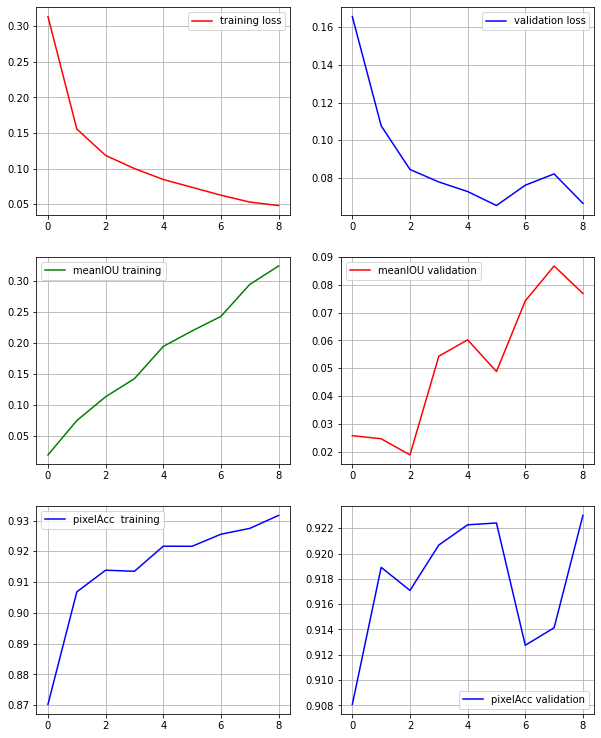

In [ ]:
#after the training loop returns, we can plot the data
# def running_mean(x, N):
#     cumsum = np.cumsum(np.insert(x, 0, 0)) 
#     return (cumsum[N:] - cumsum[:-N]) / float(N)
checkpoint = torch.load('checkpoints/checkpointroiseg9.pt')
fig, ax = plt.subplots(ncols = 2, nrows = 3, figsize = (10,13))
ax[0][0].plot(checkpoint['Training Loss'], 'r', label='training loss')
ax[0][1].plot(checkpoint['Validation Loss'], 'b', label='validation loss')
ax[1][0].plot(checkpoint['MeanIOU train'], 'g', label='meanIOU training')
ax[1][1].plot(checkpoint['MeanIOU test'], 'r', label='meanIOU validation')
ax[2][0].plot(checkpoint['PixelAcc train'], 'b', label='pixelAcc  training')
ax[2][1].plot(checkpoint['PixelAcc test'], 'b', label='pixelAcc validation')
for i in ax:
    for j in i:
        j.legend()
        j.grid(True)
plt.show()





# 'Training Loss': tr_loss_arr,
#             'Validation Loss':val_loss_arr,
#             'MeanIOU train':meanioutrain, 
#             'PixelAcc train':pixelacctrain, 
#             'MeanIOU test':meanioutest, 
#             'PixelAcc test':pixelacctest

In [ ]:
#can pass np array or path to image file
def Segment(pathtest):
    
    if isinstance(pathtest, np.ndarray):
        img = Image.fromarray(pathtest)
    else :
        img = Image.open(pathtest)
    
    preprocess = transforms.Compose([#transforms.Resize((288, 384), 2),
                                     transforms.ToTensor(),
                                     #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
    Xtest = preprocess(img.convert('RGB'))
    
    checkpoint = torch.load('checkpoints/checkpointroiseg3.pt')
    model = RoiSegModel()
    model.load_state_dict(checkpoint['state_dict'])
    with torch.no_grad():
        model.eval()
        if torch.cuda.is_available():
            dev = "cuda:0" 
        else:  
            dev = "cpu"
        device = torch.device(dev)
        model.to(device)
        Xtest = Xtest.to(device).float()
        ytest = model(Xtest.unsqueeze(0).float())
        ypos = ytest[0, 1, :, :].clone().detach().cpu().numpy()
        yneg = ytest[0, 0, :, :].clone().detach().cpu().numpy()
        ytest = ypos >= yneg
    
    mask = ytest.astype('float32')
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    mask = cv2.dilate(mask,kernel,iterations = 2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask

In [ ]:
def getcoloredMask(image, mask):
    color_mask = np.zeros_like(image)
    color_mask[:, :, 1] += mask.astype('uint8') * 250
    masked = cv2.addWeighted(image, 1.0, color_mask, 1.0, 0.0)
    return masked

In [ ]:
names = [
    '00299_RIGHT_MLO.png',
    '00202_RIGHT_MLO.png',
    '00403_RIGHT_CC.png',
]

fig, ax = plt.subplots(len(names), 3, figsize=(12, 20))
for i, n in enumerate(names):
  out = Segment('DatasetInput/test/' + n)
  img = plt.imread('DatasetInput/test/' + n)
  realroi = plt.imread('DatasetInput/ROItest/' + n)

  ax[i][0].imshow(img)
  ax[i][1].imshow(out)
  ax[i][2].imshow(realroi)

plt.show()

In [ ]:
#!for f in `cat DatasetInput/ROItooSmallNames.txt`; do mv DatasetInput/ROItrain/$f DatasetInput/ROIScartate; done
! ls -1 DatasetInput/train | wc -l

In [ ]:
#!mogrify -contrast DatasetInput/{train,ROItrain,test,ROItest}/*